# **Image Processing - Facial recognition**
---------


### **Instructions to follow:**

1. For training dataset, Download 'Group28.zip' file from the Gdrive link attached with the Gform.
2. After uploading this .ipynb file in google colab, Connect to runtime and upload 'Group28.zip' file.
3. (Very important) Starting from the first one, run the code cells one-by-one all the way to the bottom cell. It is recommended to not run previous cells in reference to the current cell.
4. In demonstration section, 2 options are given, either to manually 'Accept' or 'Reject' the cropped face pic. They are just given for the demonstration purposes only, It is recommended to accept all the images.
5. (Very important) After Each demonstration, definetly run the "Remove cropped_faces folder" cell given therewith.



### Unzipping the training dataset file.

In [ ]:
!unzip Group28.zip

Archive:  Group28.zip
  inflating: group_pic1.jpeg         
  inflating: group_pic2.jpeg         
  inflating: group_pic3.jpeg         
   creating: Data2/
  inflating: Data2/.zip              
   creating: Data2/Aryan Pal/
  inflating: Data2/Aryan Pal/aryan-pal_front.jpeg  
  inflating: Data2/Aryan Pal/WhatsApp Image 2024-11-05 at 11.16.18 PM.jpeg  
  inflating: Data2/Aryan Pal/WhatsApp Image 2024-11-05 at 11.16.20 PM.jpeg  
  inflating: Data2/Aryan Pal/WhatsApp Image 2024-11-05 at 11.16.21 PM.jpeg  
  inflating: Data2/Aryan Pal/WhatsApp Image 2024-11-05 at 11.16.22 PM.jpeg  
   creating: Data2/Dikshith Poojary/
  inflating: Data2/Dikshith Poojary/dikshith-poojary_front.jpeg  
  inflating: Data2/Dikshith Poojary/IMG20241105185952.jpg  
  inflating: Data2/Dikshith Poojary/IMG20241105190025.jpg  
  inflating: Data2/Dikshith Poojary/IMG20241105190030.jpg  
  inflating: Data2/Dikshith Poojary/IMG20241105190033.jpg  
   creating: Data2/Tejas Rana/
  inflating: Data2/Tejas Rana/tejas-rana_f

### Installing necessary libraries:

In [ ]:
!pip install mtcnn
!pip install lz4 joblib
!pip install face_recognition

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 10.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566162 sha256=acbe01595f2a2b678e69b0a8ff445b47c5e1155dfde081a5c545becc6f8eeef5
  Stored in directory: /root/.cache/pip/wheels/7a/eb/cf/e9eced74122b679557f597bb7c8e4c739cfcac526db1fd523d
Successfully built face-recognition-models


### Preprocessing & saving face images:
This code detects faces in an input image using MTCNN, then displays each face to the user in sequence, allowing them to either accept or reject each face via "Accept" and "Reject" buttons. Accepted faces are resized, cropped to focus on the face, and stored in a designated directory. Once all faces are processed, the accepted faces are saved as separate image files for later use.

In [ ]:
import cv2
import os
import numpy as np
from PIL import Image
from mtcnn import MTCNN
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from ipywidgets import Button, HBox, Text

detector = MTCNN()

accepted_faces = []
current_face_index = 0
faces = []
true_names = {}

def on_accept_clicked(face, i, button_box, name_input):
    global current_face_index
    accepted_faces.append((i, face))
    true_name = name_input.value.strip()
    if true_name:
        true_names[i] = true_name
    print(f"Accepted face {i+1} as '{true_name}'")
    button_box.close()
    show_next_face()

def on_reject_clicked(i, button_box):
    global current_face_index
    print(f"Rejected face {i+1}")
    button_box.close()
    show_next_face()

def show_next_face():
    global current_face_index, faces

    if current_face_index >= len(faces):
        print("All faces have been processed.")
        save_accepted_faces()
        return

    face = faces[current_face_index]
    bounding_box = face['box']
    x, y, width, height = bounding_box
    cropped_face = img[y:y+height, x:x+width]
    cropped_face_pil = Image.fromarray(cropped_face)
    resized_face = cropped_face_pil.resize((160, 160))

    clear_output(wait=True)
    plt.imshow(np.array(resized_face))
    plt.axis('off')
    plt.show()

    accept_button = Button(description="Accept")
    reject_button = Button(description="Reject")
    name_input = Text(placeholder="Enter true name")
    button_box = HBox([accept_button, reject_button, name_input])

    display(button_box)

    accept_button.on_click(lambda b, face=resized_face, i=current_face_index, button_box=button_box, name_input=name_input: on_accept_clicked(face, i, button_box, name_input))
    reject_button.on_click(lambda b, i=current_face_index, button_box=button_box: on_reject_clicked(i, button_box))

    current_face_index += 1

def save_accepted_faces(output_dir="cropped_faces"):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for i, face in accepted_faces:
        true_name = true_names.get(i, f"face_{i+1}")
        output_path = f"{output_dir}/{true_name}.jpeg"
        face.convert('RGB').save(output_path, format='JPEG')
        print(f"Saved accepted face {i+1} as '{true_name}' at {output_path}")

def detect_and_crop_faces(image_path, output_dir="cropped_faces"):
    global img, faces, current_face_index
    current_face_index = 0

    img = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)

    faces = detector.detect_faces(img)

    if len(faces) == 0:
        print("No faces detected.")
        return

    show_next_face()


### Facial recognition prediction and attendance logging:
---
This code loads pre-saved face encodings from subfolders (each representing an individual) and compares these with new input images to identify people and mark attendance. Each image in the input folder is compared to known encodings, and if the similarity score meets a specified threshold, the person is marked as "Present" in an Excel sheet under the current date. The system updates the attendance file, either creating it or adding to an existing log as needed.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import face_recognition
import pandas as pd
from datetime import datetime

# Initialize a global list to store all demo data
all_demos_data = []

Main_file = "/content/Data2"
Excel_file_path = "/content/attendance_sheet.xlsx"

def load_encodings_from_subfolders(main_folder):
    encodings_dict = {}
    for subfolder in os.listdir(main_folder):
        subfolder_path = os.path.join(main_folder, subfolder)
        if not os.path.isdir(subfolder_path):
            continue

        encodings = []
        for image_name in os.listdir(subfolder_path):
            if image_name.endswith(".jpeg"):
                image_path = os.path.join(subfolder_path, image_name)
                image = face_recognition.load_image_file(image_path)
                face_encodings = face_recognition.face_encodings(image)
                if face_encodings:
                    encodings.append(face_encodings[0])
                else:
                    print(f"No face detected in {image_name} in {subfolder}. Skipping.")

        if encodings:
            encodings_dict[subfolder] = np.array(encodings)
        else:
            print(f"No valid encodings found in folder: {subfolder}")

    return encodings_dict

def initialize_excel(main_folder, excel_file_path):
    if not os.path.exists(excel_file_path):
        print("Creating new Excel file for attendance summary...")
        subfolder_names = [folder_name for folder_name in os.listdir(main_folder) if os.path.isdir(os.path.join(main_folder, folder_name))]
        df = pd.DataFrame(index=subfolder_names)
        with pd.ExcelWriter(excel_file_path) as writer:
            df.to_excel(writer, sheet_name="Attendance Summary")
        print("Excel file created with initial structure.")
    else:
        print("Excel file already exists, loading it for updates.")

def compute_avg_similarity(target_encoding, folder_encodings):
    if len(folder_encodings) == 0:
        return 0

    similarities = cosine_similarity([target_encoding], folder_encodings)[0]
    return np.mean(similarities) if len(similarities) > 0 else 0

def compare_images(input_folder, main_folder, excel_file_path, similarity_threshold=0.93):
    initialize_excel(main_folder, excel_file_path)
    reference_encodings = load_encodings_from_subfolders(main_folder)
    excel_df = pd.read_excel(excel_file_path, index_col=0)
    date_column = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    if date_column not in excel_df.columns:
        excel_df[date_column] = "Absent"
    presence_dict = {person: "Absent" for person in excel_df.index}
    demo_data = []  # Store data for this demo

    for input_image_name in os.listdir(input_folder):
        if input_image_name.endswith(".jpeg"):
            true_label = input_image_name.split(".")[0]  # Use filename as true label
            input_image_path = os.path.join(input_folder, input_image_name)
            input_image = face_recognition.load_image_file(input_image_path)
            input_encodings = face_recognition.face_encodings(input_image)

            if not input_encodings:
                print(f"No face detected in {input_image_name}. Skipping this image.")
                continue

            input_encoding = input_encodings[0]
            avg_similarity_scores = {
                folder_name: compute_avg_similarity(input_encoding, folder_encodings)
                for folder_name, folder_encodings in reference_encodings.items()
            }

            best_match_folder = max(avg_similarity_scores, key=avg_similarity_scores.get)
            highest_avg_score = avg_similarity_scores[best_match_folder]
            predicted_label = best_match_folder if highest_avg_score >= similarity_threshold else "Unknown"

            print(f"Image '{input_image_name}' (True: '{true_label}') -> Predicted: '{predicted_label}', Score: {highest_avg_score:.2f}")

            presence_dict[best_match_folder] = "Present"
            demo_data.append((true_label, predicted_label, highest_avg_score))  # Save data for this demo

    all_demos_data.append(demo_data)  # Add demo data to all_demos_data

    for person, status in presence_dict.items():
        excel_df.loc[person, date_column] = status

    with pd.ExcelWriter(excel_file_path, engine="openpyxl", mode="a", if_sheet_exists="replace") as writer:
        excel_df.to_excel(writer, sheet_name="Attendance Summary")


### **Demonstration: Attendance-1**

**Note:** This manual 'Accept', 'Reject' for cropped face in group photo option is given for demonstration purposes only. In practical situations, it is NOT required as face recognition code section will take care of any non familier person, resulting in very low similarity score and hence eliminating it from the output. So we can just simply 'Accept' all the images.

In [ ]:
detect_and_crop_faces("group_pic1.jpeg")

In [ ]:
input_folder = "/content/cropped_faces"
compare_images(input_folder, Main_file, Excel_file_path)

Creating new Excel file for attendance summary...
Excel file created with initial structure.
Image 'Dikshith Poojary.jpeg' (True: 'Dikshith Poojary') -> Predicted: 'Dikshith Poojary', Score: 0.94
Image 'Aryan Pal.jpeg' (True: 'Aryan Pal') -> Predicted: 'Aryan Pal', Score: 0.94
Image 'Tejas Rana.jpeg' (True: 'Tejas Rana') -> Predicted: 'Tejas Rana', Score: 0.96


In [ ]:
print(all_demos_data)

[[('Dikshith Poojary', 'Dikshith Poojary', 0.9417313614911964), ('Aryan Pal', 'Aryan Pal', 0.9431823803454783), ('Tejas Rana', 'Tejas Rana', 0.9607870631516834)]]


**Results:**

In group_pic1, Us all 3 are present (Tejas, Aryan, Dikshith) and it correctly detects & identifies each of us.



In [ ]:
!rm -r cropped_faces/
# Must run this cell to delete 'cropped_faces' folder for group_pic1 to give the next demo a empty folder to work with.

### **Demonstration: Attendance-2**

In [ ]:
detect_and_crop_faces("group_pic2.jpeg")

In [ ]:
input_folder = "/content/cropped_faces"
compare_images(input_folder, Main_file, Excel_file_path)

Excel file already exists, loading it for updates.
Image 'Dikshith Poojary.jpeg' (True: 'Dikshith Poojary') -> Predicted: 'Dikshith Poojary', Score: 0.96
Image 'Tejas Rana.jpeg' (True: 'Tejas Rana') -> Predicted: 'Tejas Rana', Score: 0.95
Image 'Meta.jpeg' (True: 'Meta') -> Predicted: 'Unknown', Score: 0.90


**Results:**

In group_pic2, Aryan is absent. Tejas, Dikshith and a new person whose data has not been trained in the model is present. And as we can see, our model correctly identifies Tejas and Dikshith and even after accepting that new person's image, the model do not identify the person, as it should, because he is not part of training dataset.

In [ ]:
print(all_demos_data)

[[('Dikshith Poojary', 'Dikshith Poojary', 0.9417313614911964), ('Aryan Pal', 'Aryan Pal', 0.9431823803454783), ('Tejas Rana', 'Tejas Rana', 0.9607870631516834)], [('Dikshith Poojary', 'Dikshith Poojary', 0.9596412584502748), ('Tejas Rana', 'Tejas Rana', 0.9473278217029876), ('Meta', 'Unknown', 0.903053379592237)]]


In [ ]:
!rm -r cropped_faces/
# Must run this cell to delete 'cropped_faces' folder for group_pic2 to give the next demo a empty folder to work with.

### **Demonstration: Attendance-3**

In [ ]:
detect_and_crop_faces("group_pic3.jpeg")

In [ ]:
input_folder = "/content/cropped_faces"
compare_images(input_folder, Main_file, Excel_file_path)

Excel file already exists, loading it for updates.
Image 'Dikshith Poojary.jpeg' (True: 'Dikshith Poojary') -> Predicted: 'Dikshith Poojary', Score: 0.95
Image 'Aryan Pal.jpeg' (True: 'Aryan Pal') -> Predicted: 'Aryan Pal', Score: 0.96
Image 'Tejas Rana.jpeg' (True: 'Tejas Rana') -> Predicted: 'Tejas Rana', Score: 0.95
Image 'Meta.jpeg' (True: 'Meta') -> Predicted: 'Unknown', Score: 0.89


**Results:**

In group_pic3, All 3 of us (Tejas, Aryan, Dikshith), along with 1 new person are present. As we can clearly see, it correctly identifies & marks present for Tejas, Aryan and Dikshith BUT it does not identify that new person even after accepting his image, as he is not part of the training dataset.

In [ ]:
print(all_demos_data)

[[('Dikshith Poojary', 'Unknown', 0.9281035269841221), ('Aryan Pal', 'Aryan Pal', 0.9604724649099339), ('Tejas Rana', 'Tejas Rana', 0.946668380378398), ('M', 'Unknown', 0.8970882756785079)], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]


###**Mass testing:**

In [ ]:
!unzip Group_allpics.zip

Archive:  Group_allpics.zip
  inflating: WhatsApp Image 2024-11-06 at 10.53.19 PM.jpeg  
  inflating: WhatsApp Image 2024-11-06 at 10.53.21 PM.jpeg  
  inflating: WhatsApp Image 2024-11-06 at 10.53.28 PM.jpeg  
  inflating: WhatsApp Image 2024-11-07 at 12.15.03 AM.jpeg  
  inflating: WhatsApp Image 2024-11-07 at 12.15.04 AM (1).jpeg  
  inflating: WhatsApp Image 2024-11-07 at 12.15.04 AM (2).jpeg  
  inflating: WhatsApp Image 2024-11-07 at 12.15.04 AM.jpeg  
  inflating: WhatsApp Image 2024-11-07 at 12.15.05 AM (1).jpeg  
  inflating: WhatsApp Image 2024-11-07 at 12.15.05 AM (2).jpeg  
  inflating: WhatsApp Image 2024-11-07 at 12.15.05 AM.jpeg  
  inflating: WhatsApp Image 2024-11-07 at 12.15.06 AM (1).jpeg  
  inflating: WhatsApp Image 2024-11-07 at 12.15.06 AM.jpeg  
  inflating: WhatsApp Image 2024-11-13 at 10.57.42 PM.jpeg  
  inflating: WhatsApp Image 2024-11-13 at 10.57.44 PM.jpeg  
  inflating: WhatsApp Image 2024-11-13 at 10.57.46 PM (1).jpeg  
  inflating: WhatsApp Image 2024-

In [ ]:
detect_and_crop_faces("/content/WhatsApp Image 2024-11-13 at 10.57.47 PM.jpeg")

In [ ]:
input_folder = "/content/cropped_faces"
compare_images(input_folder, Main_file, Excel_file_path)

Excel file already exists, loading it for updates.
Image 'Tejas Rana.jpeg' (True: 'Tejas Rana') -> Predicted: 'Tejas Rana', Score: 0.96
Image 'Dikshith Poojary.jpeg' (True: 'Dikshith Poojary') -> Predicted: 'Dikshith Poojary', Score: 0.94
No face detected in Aryan Pal.jpeg. Skipping this image.


In [ ]:
print(len(all_demos_data))
print(all_demos_data)

21
[[('Dikshith Poojary', 'Dikshith Poojary', 0.9530421428766769)], [('Dikshith Poojary', 'Dikshith Poojary', 0.9585939103643857)], [('Mihir', 'Unknown', 0.8787929100181824), ('Dikshith Poojary', 'Dikshith Poojary', 0.935448651915373), ('Anirudhh', 'Unknown', 0.8794648886331579)], [('Mihir', 'Unknown', 0.8876140009624051), ('Dikshith Poojary', 'Unknown', 0.928153089465007), ('Anirudhh', 'Unknown', 0.8784901189513014)], [('Mihir', 'Unknown', 0.8922776400429877), ('Dikshith Poojary', 'Dikshith Poojary', 0.9300687878624896), ('Anirudhh', 'Unknown', 0.8714231850803703)], [('Mukund', 'Unknown', 0.8911718544134096), ('Tejas Rana', 'Tejas Rana', 0.9371847533779588), ('Dikshith Poojary', 'Dikshith Poojary', 0.9543349379782111), ('Aryan Pal', 'Aryan Pal', 0.947226434220917)], [('Mukund', 'Unknown', 0.8946622239046628), ('Tejas Rana', 'Tejas Rana', 0.9487084630887199), ('Dikshith Poojary', 'Dikshith Poojary', 0.9509881568497256), ('Aryan Pal', 'Aryan Pal', 0.9558497458666556)], [('Mukund', 'Unkn

In [ ]:
!rm -r cropped_faces/
# Must run this cell to delete 'cropped_faces' folder for group_pic1 to give the next demo a empty folder to work with.

Saving this data:

In [ ]:
import pickle

# Save to a file
save_path = "/content/all_demos_data.pkl"
with open(save_path, "wb") as file:
    pickle.dump(all_demos_data, file)

print(f"Data saved successfully to {save_path}")

Data saved successfully to /content/all_demos_data.pkl


To load the data file for later use:

In [ ]:
import pickle

# Load from the file
load_path = "/content/all_demos_data.pkl"
with open(load_path, "rb") as file:
    loaded_all_demos_data = pickle.load(file)

print("Data loaded successfully:")
print(loaded_all_demos_data)

### **Attendance Sheet (Excel File)**

In [ ]:
try:
    attendance_sheet = pd.read_excel(Excel_file_path, index_col=0, engine='openpyxl')
except Exception as e:
    print("Error reading Excel file:", e)
    raise
print(attendance_sheet)

                 2024-11-13 18:21:15 2024-11-13 18:25:11 2024-11-13 18:27:00  \
Dikshith Poojary             Present             Present             Present   
Tejas Rana                    Absent              Absent              Absent   
Aryan Pal                     Absent              Absent              Absent   

                 2024-11-13 18:29:21 2024-11-13 18:30:48 2024-11-13 18:33:32  \
Dikshith Poojary             Present             Present             Present   
Tejas Rana                    Absent              Absent             Present   
Aryan Pal                    Present             Present             Present   

                 2024-11-13 18:35:31 2024-11-13 18:36:43 2024-11-13 18:37:59  \
Dikshith Poojary             Present             Present             Present   
Tejas Rana                   Present             Present             Present   
Aryan Pal                    Present              Absent              Absent   

                 2024-11-13 18:39:20 

## **Analysis:**
---

Confusion Matrix:
[[ 0  0  0  0  0  0]
 [ 0 17  0  0  0  0]
 [ 0  0  0  0  0  0]
 [ 0  0  0  0  0  0]
 [ 0  0  0  0 15  0]
 [ 0  0  0  0  0 10]]


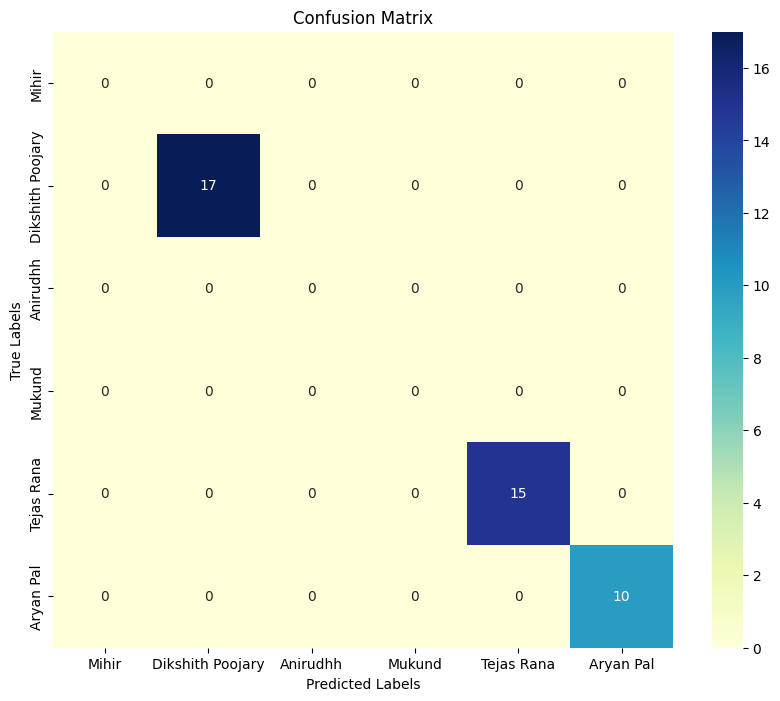

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Precision, Recall, and F1 Score for Each Label:
Mihir:
  Precision: 0.00
  Recall: 0.00
  F1 Score: 0.00
Dikshith Poojary:
  Precision: 1.00
  Recall: 0.81
  F1 Score: 0.89
Anirudhh:
  Precision: 0.00
  Recall: 0.00
  F1 Score: 0.00
Mukund:
  Precision: 0.00
  Recall: 0.00
  F1 Score: 0.00
Tejas Rana:
  Precision: 1.00
  Recall: 1.00
  F1 Score: 1.00
Aryan Pal:
  Precision: 1.00
  Recall: 1.00
  F1 Score: 1.00

Overall Accuracy: 68.85%


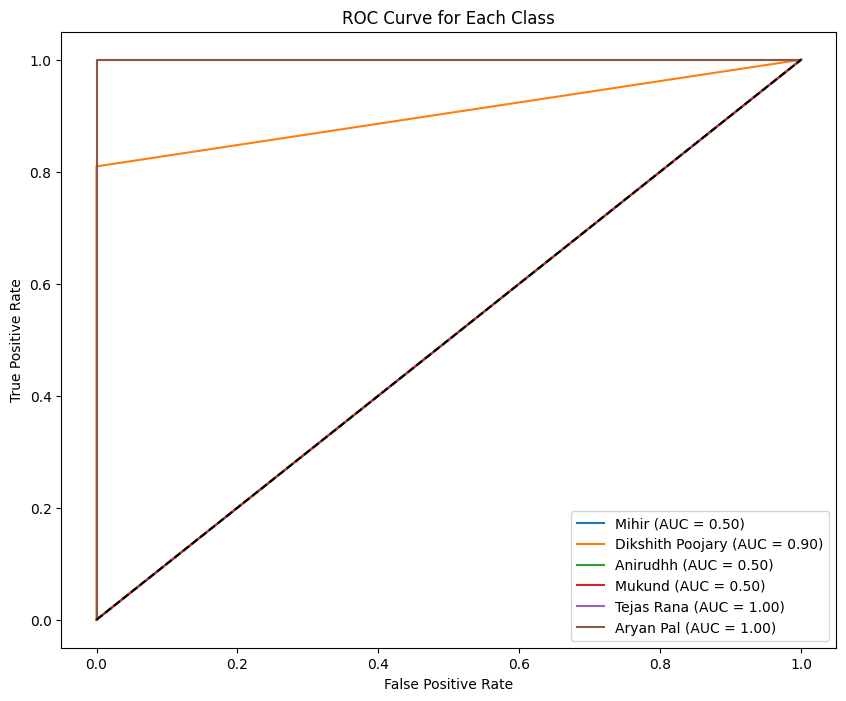

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
import seaborn as sns

flat_data = [item for demo in all_demos_data for item in demo]

true_labels = [entry[0] for entry in flat_data]
predicted_labels = [entry[1] for entry in flat_data]
similarity_scores = [entry[2] for entry in flat_data]

unique_labels = list(set(true_labels))

conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=unique_labels)
print("Confusion Matrix:")
print(conf_matrix)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu", xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Precision, Recall, and F1 Score for each label
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average=None, labels=unique_labels)
print("\nPrecision, Recall, and F1 Score for Each Label:")
for i, label in enumerate(unique_labels):
    print(f"{label}:")
    print(f"  Precision: {precision[i]:.2f}")
    print(f"  Recall: {recall[i]:.2f}")
    print(f"  F1 Score: {f1[i]:.2f}")

# End-to-End Accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"\nOverall Accuracy: {accuracy * 100:.2f}%")

# ROC Curve and AUC
true_labels_binarized = label_binarize(true_labels, classes=unique_labels)
predicted_labels_binarized = label_binarize(predicted_labels, classes=unique_labels)

plt.figure(figsize=(10, 8))
for i, label in enumerate(unique_labels):
    fpr, tpr, _ = roc_curve(true_labels_binarized[:, i], predicted_labels_binarized[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend(loc="lower right")
plt.show()
